In [11]:
import gymnasium as gym
from gymnasium import wrappers
import ale_py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [30]:
gym.register_envs(ale_py)
env = gym.make('BreakoutNoFrameskip-v4', render_mode="rgb_array")
env = wrappers.AtariPreprocessing(env)
env = wrappers.FrameStackObservation(env, 4)
obs, info = env.reset()
obs = np.transpose(obs, axes=[1, 2, 0])

In [23]:
num_actions = 4
def create_q_model():
    inputs = layers.Input(shape=(84, 84, 4))
    layer1 = layers.Conv2D(32, 8, strides=4, activation='relu')(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation='relu')(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation='relu')(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation='relu')(layer4)
    action = layers.Dense(num_actions, activation='linear')(layer5)
    return keras.Model(inputs=inputs, outputs=action)

model = create_q_model()
model_target = create_q_model()

In [24]:
gamma = 0.99  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

In [32]:
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

while True:
    state, _ = env.reset()
    state = np.transpose(state, axes=[1, 2, 0])
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1
        if frame_count < epsilon_random_frames or epsilon > np.random.rand():
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()
        # Decay probability of taking random action
        if frame_count < epsilon_greedy_frames:
            epsilon -= epsilon_interval_1 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_1)
        
        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
            epsilon -= epsilon_interval_2 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_2)
        
        if frame_count > 2 * epsilon_greedy_frames:
            epsilon -= epsilon_interval_3 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_3)
        
        state_next, reward, done, truncated, _ = env.step(action)
        state_next = np.transpose(state_next, axes=[1, 2, 0])

        episode_reward += reward

        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done or truncated)
        rewards_history.append(reward)
        state = state_next

        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])
            future_rewards = model_target.predict(state_next_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample
            masks = tf.one_hot(action_sample, num_actions)
            with tf.GradientTape() as tape:
                q_values = model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks))
                loss = loss_function(updated_q_values, q_action)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        if frame_count % update_target_network == 0:
            model_target.ste_weights(model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))
        
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break
    
     # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 18:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

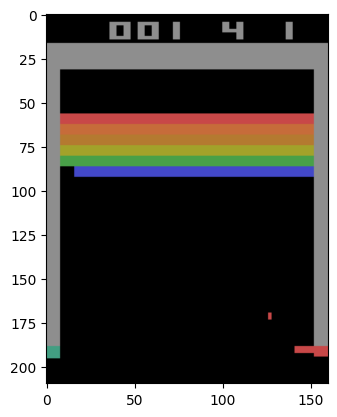

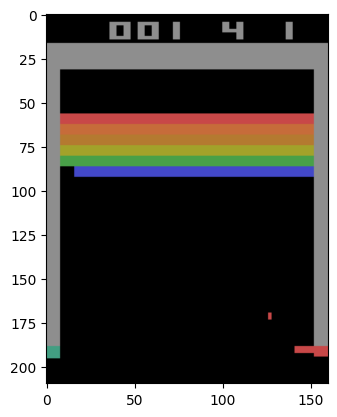

In [5]:
%matplotlib inline
gym.register_envs(ale_py)
fig = plt.figure()
hfig = display(fig, display_id=True)

env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
obs, info = env.reset()
for _ in range(100):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    plt.clf()
    plt.imshow(obs)
    fig.canvas.draw()
    hfig.update(fig)
    # print(obs, reward, terminated, truncated, info)
    if terminated or truncated:
        obs, info = env.reset()
env.reset()
env.close()